# Part o Speech Tagging of Portugese Sentences

Part of speech (PoS) taggins is a fundamental technique in most natural language recognition projects, in which we try to determine the role each word plays on a sentence. For example, the sentence "Toto, I have a feeling that we are not in Kansas anymore." could be tagged as:

| Word    | Tag         |
|---------|-------------|
| Toto    | Proper noun |
| ,       | Punctuation |
| I       | Pronoun     |
| have    | Verb        |
| a       | Determiner  |
| feeling | Noun        |
| that    | Preposition |
| we      | Pronoun     |
| are     | Verb        |
| not     | Adverb      |
| in      | Preposition |
| Kansas  | Noun        |
| anymore | Adverb      |
| .       | Punctuation |

However, on this notebook, we will be performing PoS tagging over portuguese sentences, as english PoS tagging has already been covered in many other projects. Therefore, this discussion will be carried out in portuguese from this point onwards.

If you want to learn about PoS tagging in english, you can read [this article](https://medium.com/data-science-in-your-pocket/pos-tagging-using-hidden-markov-models-hmm-viterbi-algorithm-in-nlp-mathematics-explained-d43ca89347c4) by Mehul Gupta who does a job that is honestly better than mine on explaining the topic in detail. You can also easily find [many implementations of PoS tagging on GitHub](https://github.com/search?q=pos-tagging).

## Hidden Markov Model

Nesses exemplos, usaremos a implementação do algoritmo _Hidden Markov Model_ (Modelo Oculto de Markov) oferecido pela biblioteca `nltk`. Esse modelo tem diversas aplicações além de _PoS tagging_ em áreas como termodinâmica, estatística, ecnomia, teoria da informação, entre outras.

Teremos um processo estocástico, mais especificamente um processo Markoviano, ou seja, temos uma sequência de variáveis aleatórias que podem assumir um conjunto de estados $Q$ onde a probabilidade de cada estado depende apenas do estado assumido na variável anterior, chamaremos essa sequência de $X$. Teremos também uma senquência de valores observáveis $Y$ onde a ocorrência de $y_n$ está relacionada com a ocorrência de $x_n$. Baseado nisso teremos duas tabelas de probabilidade: as probabilidades de transição e as probabilidades de emissão. As probabilidades de transição indicam a probabilidade de $x_n$ assumir um dado estado baseado no estado de $x_{n-1}$:

$$P(x_n|x_{n-1})$$

Enquanto as probabilidades de emissão indicam a probabilidade de um observável $y_n$ ser emitido por um estado $q$:

$$P(y_n|x_n)$$

No nosso caso, os estados assumíveis serão classes de palavras existentes na língua portugesa que aqui serão representados com: 

| Classe de palavra                      | Tag        |
|----------------------------------------|------------|
| Artigo                                 | ART        |
| Adjetivo                               | ADJ        |
| Nome                                   | N          |
| Nome próprio                           | NPROP      |
| Numeral                                | NUM        |
| Pronome adjetivo                       | PROADJ     |
| Pronome substantivo                    | PROSUB     |
| Pronome pessoal                        | PROPESS    |
| Pronome conectivo subordinado          | PRO-KS     |
| Pronome conectivo subordinado relativo | PRO-KS-REL |
| Advérbio                               | ADV        |
| Advérbio conectivo subordinativo       | ADV-KS     |
| Advérbio relativo subordinativo        | ADV-KS-REL |
| Conjunção coordenativa                 | KC         |
| Conjunção subordinativa                | KS         |
| Preposição                             | PREP       |
| Interjeição                            | IN         |
| Verbo                                  | V          |
| Verbo auxiliar                         | VAUX       |
| Particípio                             | PCP        |
| Palavra denotativa                     | PDEN       |
| Pontuação.                             | PU         |
| Moeda corrente                         | CUR        |

as tags ainda podem ser acompanhadas de informações adicionais denotadas por:

| Informação            | Modificador (_TAG_\|MOD) |
|-----------------------|--------------------------|
| Estrangeirismo        | EST                      |
| Apostos               | AP                       |
| Dados                 | DAD                      |
| Números de telefone   | TEL                      |
| Datas                 | DAT                      |
| Horas                 | HOR                      |
| Contrações e ênclises | +                        |
| Mesóclise             | !                        |


A sequência $X$ será a sequência de tags atribuídas a uma sentença fornecida e a sequência $Y$ será composta das palavras que formam a sentença. Ou seja, teremos que as probabilidades de transição serão probabilidades de que uma classe de palavra seja precedida por outra, enquanto as probabilidades de emissão serão as probabilidades de que uma determinada palavra tenha o papel de uma determinada classe de discurso. Por exemplo, suponha que tenhamos apenas três classes de palavras: nomes, verbos e advérbios, uma possível tabela de probabilidades de transição seria:

|              | **Nome** | **Verbo** | **Advérbio** |
|--------------|----------|-----------|--------------|
| **Nome**     | 0.6      | 0.1       | 0.3          |
| **Verbo**    | 0.5      | 0.1       | 0.4          |
| **Advérbio** | 0.5      | 0.4       | 0.1          |

caso o nosso vocabulário possua apenas as palavras armando, faz e rapidamente, uma possível tabela de probabilidades de emissão seria:

|                 | **Nome** | **Verbo** | **Advérbio** |
|-----------------|----------|-----------|--------------|
| **Armando**     | 0.5      | 0.5       | 0.0          |
| **Faz**         | 0.1      | 0.9       | 0.0          |
| **Rapidamente** | 0.0      | 0.0       | 1.0          |

O _Hidden Markov Model_ monta uma máquina de estados e trabalha com iterações baseadas nas duas probabilidades mencionadas para convergir e determinar uma classificação adequada para as palavras de uma sentença. Essas probabilidades são calculadas a partir de uma análise dos dados de treino fornecidos. Veremos agora o exemplo utilizando a implementação da `nltk` do algoritmo.

## Implementação

In [1]:
import numpy as np
import nltk
from typing import Tuple
from matplotlib import pyplot as plt
from nltk.tag.hmm import HiddenMarkovModelTrainer
from nltk.tag import HiddenMarkovModelTagger
from random import randint
from pandas import DataFrame

Utilizaremos o corpus disponível [nesse link](http://nilc.icmc.usp.br/macmorpho/macmorpho-v3.tgz) cuja documentação pode ser obtida [aqui](http://nilc.icmc.usp.br/macmorpho/macmorpho-manual.pdf).

In [2]:
corpus_train_path = './macmorpho-train.txt'
corpus_test_path = './macmorpho-test.txt'

A função `read_tags` recebe o caminho para o arquivo e realiza o pré processamento do texto. Em primeiro lugar, colocamos todo o texto em letras minúsculas para evitar problemas. Em seguida observamos o formato do corpus que é uma sequência de tokens `PALAVRA_TAG` separados por espaço ou quebra de linha, então substituímos todos as quebras de linha por espaços e fazemos um split nesses espaços para separar esses tokens. Então fazemos um split por "_" para criar tuplas `(PALAVRA, TAG)`. Por fim, separamos o texto em sentenças assumindo que sentenças terminam em ".", "!" ou "?".

A função `read_sentence_text` é um helper que converte um vetor de tuplas na frase original.

In [3]:
def read_tags(corpus_path: str):
    corpus_file = open(corpus_path, encoding='utf-8')
    corpus = corpus_file.read().replace('\n', ' ').lower()
    words = [tuple(word_tag.split('_')) for word_tag in corpus.split(' ')]
    
    sentences = [[]]
    sentence_terminators = ['.', '!', '?']
    for word in words:
        sentences[-1].append(word)
        if word[0] in sentence_terminators:
            sentences.append([])
    sentences.pop()        
    
    return sentences

def read_sentence_text(sentence: list):
    return ' '.join([word[0] for word in sentence])

Então pre-processamos nosso corpus e treinamos o modelo com a classe `HiddenMarkovModelTrainer` do módulo `hmm` da `nltk`.

In [4]:
sentences = read_tags(corpus_train_path)
trainer = HiddenMarkovModelTrainer()
tagger = trainer.train_supervised(sentences[:34724])

Um exemplo da nossa organização dos dados é apresentado abaixo:

In [5]:
sentence_index = randint(0, len(sentences))
print("Frase:")
print(read_sentence_text(sentences[sentence_index]))
print("Representação:")
DataFrame(sentences[sentence_index])

Frase:
em seguida vêm os produtos matinais , com 51,3 % em um mês .
Representação:


,0,1
0,em,adv
1,seguida,adv
2,vêm,v
3,os,art
4,produtos,n
5,matinais,adj
6,",",pu
7,com,prep
8,"51,3",num
9,%,n


Com o modelo treinado, podemos realizar amostras de classificações para palavras com as funções abaixo.

In [6]:
def tag_word(word: str):
  return tagger.tag([word.lower()])[0][1]

def tag_sentence(sentence: str):
  return tagger.tag_sents([sentence.split(' ')])[0]

def print_tag(word: str):
  print(f'{word}:', tag_word(word))

Palavras:

In [7]:
print_tag('fugiu')
print_tag('escritório')
print_tag('rapidamente')
print_tag('R$')
print_tag('armando')
print_tag('seu')
print_tag('feliz')

fugiu: v
escritório: n
rapidamente: adv
R$: cur
armando: nprop
seu: proadj
feliz: nprop


Sentenças:

In [8]:
tag_sentence('mesmo estando atrasado , parou para cumprimentá-lo')

[('mesmo', 'pden'),
 ('estando', 'v'),
 ('atrasado', 'pcp'),
 (',', 'pu'),
 ('parou', 'v'),
 ('para', 'prep'),
 ('cumprimentá-lo', 'n')]

In [9]:
tag_sentence('o galo ganhou mais uma vez , ai credo')

[('o', 'art'),
 ('galo', 'n'),
 ('ganhou', 'v'),
 ('mais', 'adv'),
 ('uma', 'art'),
 ('vez', 'n'),
 (',', 'pu'),
 ('ai', 'in'),
 ('credo', 'n')]

In [10]:
tag_sentence('que a força esteja com você')

[('que', 'ks'),
 ('a', 'art'),
 ('força', 'n'),
 ('esteja', 'v'),
 ('com', 'prep'),
 ('você', 'propess')]

## Testes do modelo

Agora que entendemos de modo geral a ideia de como o _Hidden Markov Model_ funciona e temos um modelo treinado, podemos verificar se o método realmente funciona.

Vamos utilizar o conjunto de dados de teste incluso no corpus para testar a qualidade do modelo. A função `test_model` testa os resultados preditos pelo modelo em relação as respostas dos dados de teste e retorna o número de acertos, o número de erros e uma tabela que mostra como as predições se relacionam com as respostas corretas.

In [11]:
tags = [
        "ART", "ADJ", "N", "NPROP", "PROADJ", "PROSUB",
        "PROPESS", "PRO-KS", "ADV", "ADV-KS", "KC", "KS",
        "PREP", "IN", "V", "PCP", "PDEN", "CUR", "NUM", "PU"
       ]

def get_tag_type(tagged_word: Tuple[str, str]):
  tag = tagged_word[1]
  if '|' in tag:
    tag = tag.split('|')[0]
  if '+' in tag:
    tag = tag.split('+')[0]
  return tag.upper()

def test_model(tagger: HiddenMarkovModelTagger, predictions: list, test_sentences: list):
  hit = 0
  miss = 0
  results = DataFrame(data=[[0 for tag in tags] for tag in tags], columns=tags, index=[tags])
  for i in range(len(predictions)):
    for j in range(len(predictions[i])):
      prediction = get_tag_type(predictions[i][j])
      answer = get_tag_type(test_sentences[i][j])
      if(prediction == answer):
        hit += 1
      else:
        miss += 1
      results[answer][prediction] += 1

  return (hit, miss, results)

In [12]:
test_sentences = read_tags(corpus_test_path)
predictions = tagger.tag_sents([[word[0] for word in sentence] for sentence in test_sentences])
hit, miss, result = test_model(tagger, predictions, test_sentences)

Como podemos verificar, o modelo acertou 119.585 classificações enquanto errou 58.788 delas, isso representa uma taxa de acerto de aproximadamente 67%, o que é uma taxa razoável especialmente considerando que ela poderia provavelmente ser melhorada com ajustes nos parâmetros de treino.

In [13]:
print('Acertos:', hit)
print('Erros:', miss)

Acertos: 116743
Erros: 61630


Abaixo observamos os resultados obtidos no teste, as linhas representam a predição enquanto as colunas representam a resposta correta para a palavra. Podemos perceber que o erro mais comum é a classificação incorreta de palavras como nomes, isso provavelmente é devido ao fato dos nomes serem uma classe de palavras mais geral que as outras, portanto, pela característica do aprendizado de máquina, quando o modelo não sabe qual classe atribuir a uma palavra, ele tende a optar por uma classificação menos específica. 

In [14]:
result.to_csv('./test-result.csv')
result

,ART,ADJ,N,NPROP,PROADJ,PROSUB,PROPESS,PRO-KS,ADV,ADV-KS,KC,KS,PREP,IN,V,PCP,PDEN,CUR,NUM,PU
ART,8624,0,3,96,3,42,23,4,18,0,0,4,199,2,0,0,0,0,91,0
ADJ,0,4318,382,247,14,3,0,0,39,0,0,0,13,1,11,15,3,0,0,0
N,3804,4078,35458,8384,1237,403,854,923,1750,96,1924,762,10402,40,6753,1647,328,80,947,12100
NPROP,14,79,395,6641,3,5,4,1,6,0,17,1,99,6,22,5,0,1,5,0
PROADJ,0,10,10,12,2031,63,0,11,81,0,0,1,1,0,0,0,5,0,0,0
PROSUB,19,1,4,2,48,868,1,74,22,0,0,8,5,0,1,0,4,0,4,0
PROPESS,1,0,0,5,1,1,1955,0,0,0,0,84,3,1,0,0,0,0,0,0
PRO-KS,3,1,0,2,8,134,14,1091,9,2,0,181,1,0,0,0,3,0,0,0
ADV,1,20,21,13,37,15,0,0,3140,2,54,42,182,7,4,0,42,0,2,0
ADV-KS,0,0,0,0,0,0,0,0,17,70,0,36,2,0,0,0,0,0,0,0


No gráfico abaixo podemos ver como essa característica está refletida na taxa de acertos dos nomes que é muito próxima de 1, em mais de 90% dos casos o modelo classifica nomes corretamente.

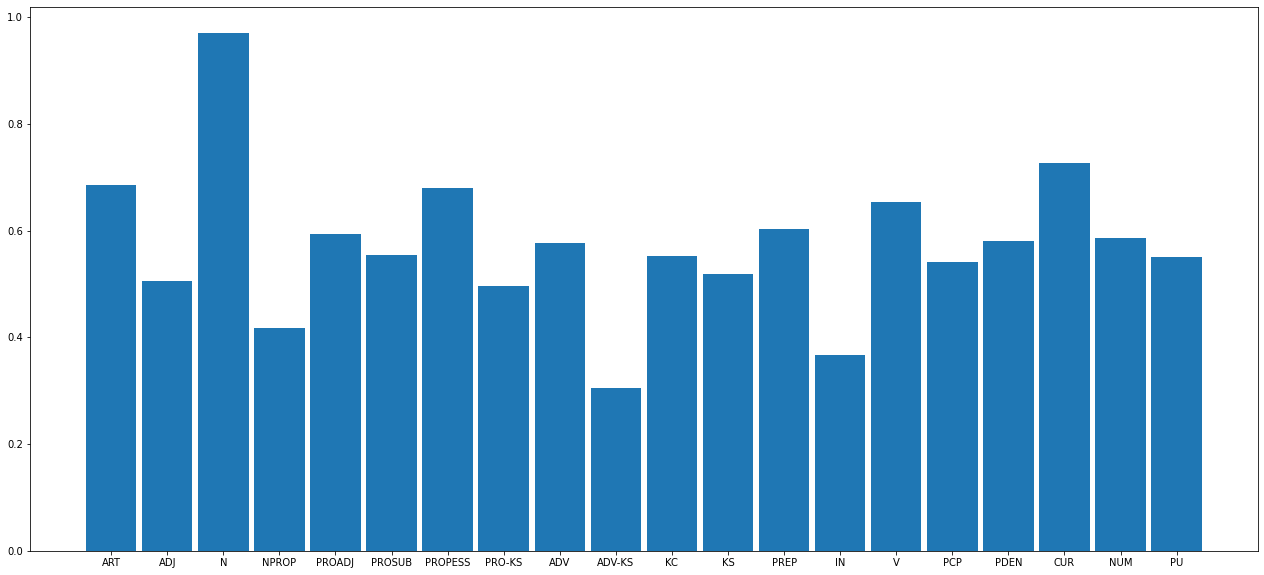

In [15]:
accuracies = [result[tag][tag]/(result[tag].sum()) for tag in tags]
plt.figure(figsize=(22, 10))
plt.bar(tags, accuracies, .9)
plt.show()

Outro ponto interessante a se notar, é que as classes de palavras mais comuns como artigos, nomes, pronomes e verbos têm as maiores acuracias, cerca de 70% em todos os casos, o que significa que nos casos mais comuns, a classificação é eficaz. Moedas também apresentaram uma boa precisão, provavelmente devido ao fato de que representações de moedas tendem a ser mais específicas, já que são um grupo muito restrito e frequentemente incluem caracteres que não estão contidos no alfabeto da língua portugesa. Dentre as classes com menor precisão, podemos comentar que os nomes próprios muitas vezes são confundidos com nomes pelos modelos, possivlemente porque deixamos todo o texto em letras minúsculas no nosso pré processamento de dados. Outra classe com baixa precisão são as interjeições, que frequentemente serão palavras também utilizadas em outros contextos.